In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import cos, sin, exp, pi
import seaborn as sns
sns.set_style("whitegrid", {'grid.linestyle': '--'})

3.1 線形基底関数モデル

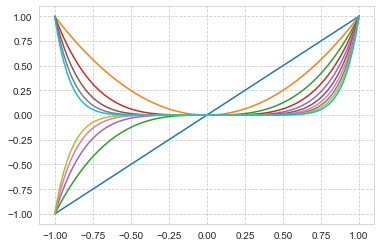

In [2]:
# 基底関数：多項式
y = 0
x = np.linspace(-1, 1, 100)
for i in range(1, 11):
    y = x**i
    plt.plot(x, y)

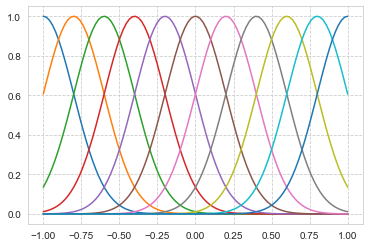

In [3]:
# 基底関数：ガウス基底関数
y = 0
x = np.linspace(-1, 1, 100)
for mu in np.linspace(-1, 1, 11):
    y = exp(-(x-mu)**2/ (2*(0.2)**2))
    plt.plot(x, y)


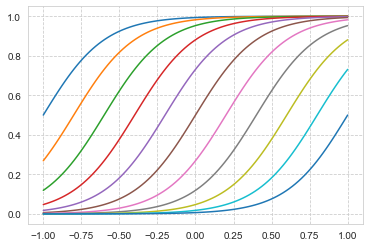

In [6]:
# 基底関数：シグモイド関数
for mu in np.linspace(-1, 1, 11):
    y = 1 / (1+exp(-((x-mu) / 0.2)))
    plt.plot(x, y)
